In [2]:
import os
import pandas as pd
from langid import classify

import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np
from tqdm import tqdm

# Importing dataset

In [3]:
li = []
for filename in os.listdir("../challenge_data/train_tweets"):
    df = pd.read_csv("../challenge_data/train_tweets/" + filename)
    li.append(df)
df = pd.concat(li, ignore_index=True)

In [24]:
print(df.head())
print("\n")
print(df.shape)

    ID  MatchID  PeriodID  EventType      Timestamp  \
0  2_0        2         0          0  1403538600000   
1  2_0        2         0          0  1403538600000   
2  2_0        2         0          0  1403538600000   
3  2_0        2         0          0  1403538600000   
4  2_0        2         0          0  1403538600000   

                                               Tweet  Character_Count  
0  RT @soccerdotcom: If #ESP beats #AUS we'll giv...              140  
1  Visit the #SITEP official web site here http:/...              135  
2  RT @soccerdotcom: If #ESP beats #AUS we'll giv...              140  
3  RT @worldsoccershop: If there is a winner in t...              140  
4  RT @soccerdotcom: If #AUS beats #ESP we'll giv...              140  


(5056050, 7)


In [44]:
matches = {}
for filename in os.listdir("../challenge_data/train_tweets"):
    df_ = pd.read_csv("../challenge_data/train_tweets/" + filename)["MatchID"]
    match_id = df_.iloc[0]
    matches[match_id] = filename[:-6]

print(matches)

{2: 'AustraliaSpain', 3: 'PortugalGhana', 8: 'CameroonBrazil', 1: 'GermanyBrazil', 14: 'BelgiumSouthKorea', 7: 'NetherlandsChile', 4: 'GermanyAlgeria', 5: 'FranceGermany', 19: 'MexicoCroatia', 13: 'FranceNigeria', 12: 'AustraliaNetherlands', 0: 'HondurasSwitzerland', 10: 'ArgentinaGermanyFinal', 11: 'ArgentinaBelgium', 18: 'USASlovenia20', 17: 'GermanyUSA'}


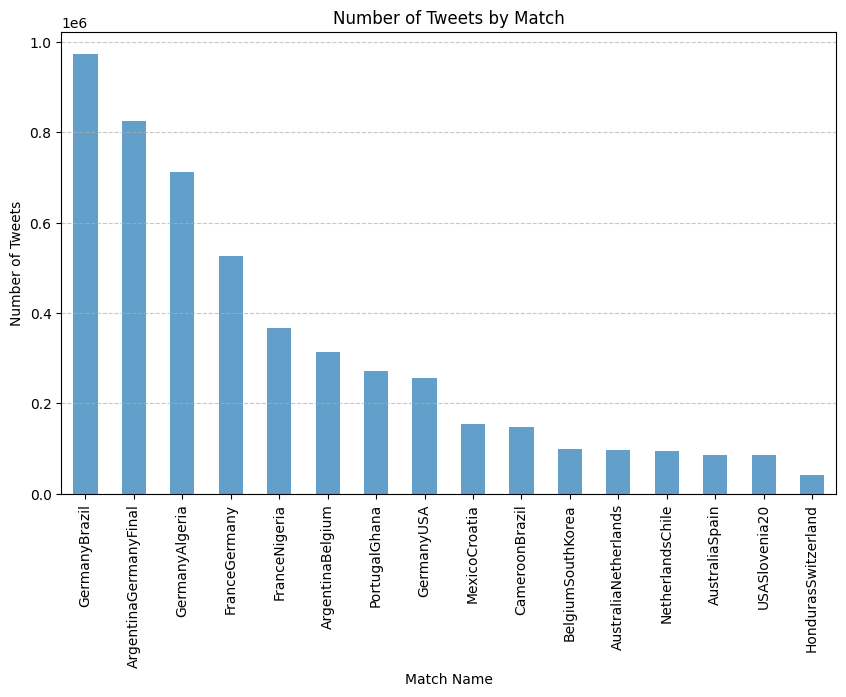

In [45]:
# Plot histogram of the number of tweets by match
plt.figure(figsize=(10, 6))
df['MatchID'].map(matches).value_counts().plot(kind='bar', alpha=0.7)
plt.title("Number of Tweets by Match")
plt.xlabel("Match Name")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

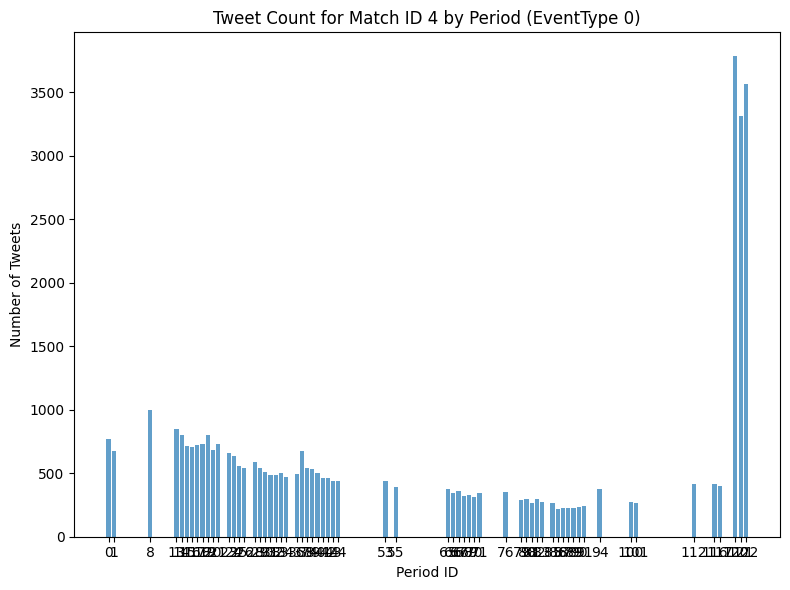

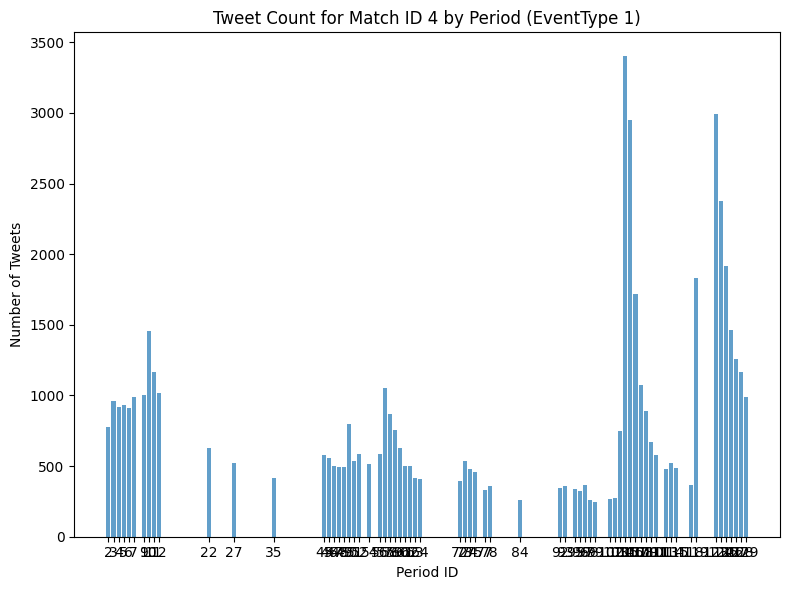

In [ ]:
# Filter data for MatchID = 7
match_data = df[df['MatchID'] == 7]

# Group by PeriodID and EventType, counting tweets
tweets_by_period_event = match_data.groupby(['PeriodID', 'EventType']).size().reset_index(name='Tweet_Count')

# Plot the results
for event_type in tweets_by_period_event['EventType'].unique():
    subset = tweets_by_period_event[tweets_by_period_event['EventType'] == event_type]
    plt.figure(figsize=(8, 6))
    plt.bar(subset['PeriodID'], subset['Tweet_Count'], alpha=0.7)
    plt.title(f"Tweet Count for Match ID 7 by Period (EventType {event_type})")
    plt.xlabel("Period ID")
    plt.ylabel("Number of Tweets")
    plt.xticks(subset['PeriodID'])
    plt.tight_layout()
    plt.show()

100%|██████████| 5056050/5056050 [00:08<00:00, 591252.80it/s]


   EventType  Total_Count
0          0         4869
1          1         4747
Average Ratio of Football Terms to Total Words by EventType:
   EventType  FootballWordRatio
0          0           0.000158
1          1           0.000129
Total Count of Football Terms by EventType:
   EventType  Total_Count
0          0         4869
1          1         4747


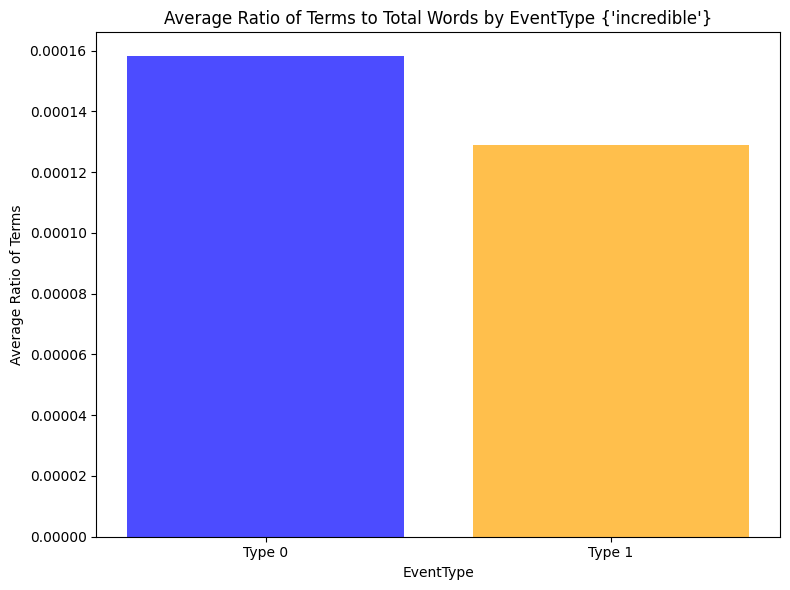

100%|██████████| 5056050/5056050 [00:08<00:00, 616152.67it/s]


   EventType  Total_Count
0          0         4781
1          1         7635
Average Ratio of Football Terms to Total Words by EventType:
   EventType  FootballWordRatio
0          0           0.000238
1          1           0.000312
Total Count of Football Terms by EventType:
   EventType  Total_Count
0          0         4781
1          1         7635


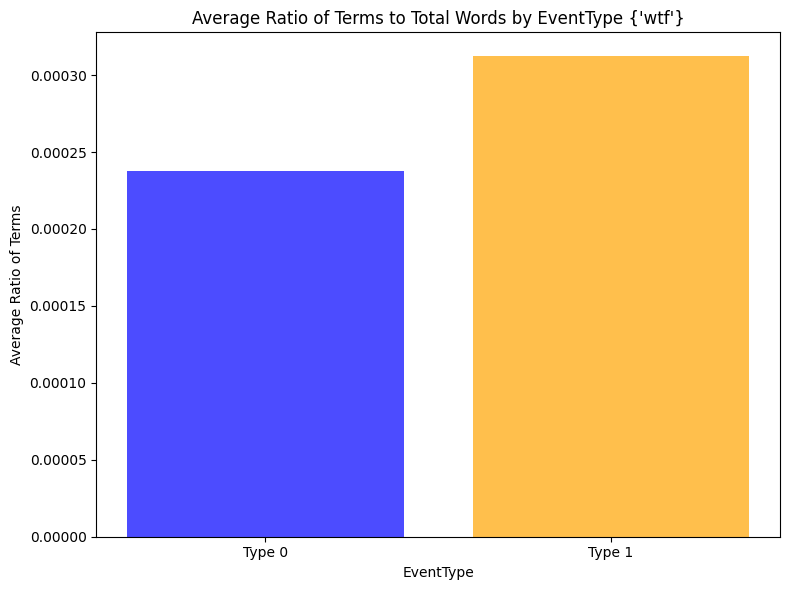

In [ ]:




def analyse_terms(football_terms, df):
    def match_football_terms(text):
        # Create a pattern to match variations of football terms
        text.lower()
        pattern = r'\b(?:' + '|'.join([f'{term}+' for term in football_terms]) + r')\b'
        matches = re.findall(pattern, text.lower())
        return matches

    # Apply preprocessing and count words in football terms for the whole dataset
    tqdm.pandas()
    df['TotalWords'] = df['Tweet'].progress_apply(lambda x: len(x.split()))
    df['MatchedTerms'] = df['Tweet'].progress_apply(match_football_terms)
    df['FootballWords'] = df['MatchedTerms'].apply(len)

    # Explode to create one row per matched term
    exploded_data = df.explode('MatchedTerms')

    # Drop rows with NaN after exploding
    exploded_data = exploded_data.dropna(subset=['MatchedTerms'])

    # Group by EventType and count occurrences of football terms
    total_counts = (
        exploded_data.groupby(['EventType', 'MatchedTerms'])
        .size()
        .reset_index(name='Total_Count')
    )

    # Aggregate the total count of terms for each EventType
    event_type_totals = total_counts.groupby('EventType')['Total_Count'].sum().reset_index()

    # Display the results
    print(event_type_totals)

    df['FootballWordRatio'] = df['FootballWords'] / df['TotalWords']


    # Calculate the average ratio for each EventType
    average_ratios = df.groupby('EventType')['FootballWordRatio'].mean().reset_index()
    # Display the average ratios
    print("Average Ratio of Football Terms to Total Words by EventType:")
    print(average_ratios)

    # Display the total counts
    print("Total Count of Football Terms by EventType:")
    print(event_type_totals)

    # Plot the comparison
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    plt.bar(average_ratios['EventType'], average_ratios['FootballWordRatio'], alpha=0.7, color=['blue', 'orange'])
    plt.title(f"Average Ratio of Terms to Total Words by EventType {football_terms}")
    plt.xlabel("EventType")
    plt.ylabel("Average Ratio of Terms")
    plt.xticks([0, 1], labels=["Type 0", "Type 1"])
    plt.tight_layout()
    plt.show()


    # counted_words = total_counts['MatchedTerms'].unique()
    # print("List of counted words:")
    # print(counted_words)

# # Define football terms and a function to match similar words
# football_terms = {"goal", "penalty", "offside", "yellow", "red", "card", "corner", "free", "kick", "var","kickoff" }
# analyse_terms(football_terms, df)

# no_event_terms = {
#     "boring", "nothing happened", "dull", "slow", "lackluster",
#     "no action", "disappointing", "what a waste",
#     "possession", "strategy", "formation", "passing", "defense",
#     "midfield", "control", 
#     "waiting...",   "end-to-end", "offside"
#      "offside flag", "tight defense", "no creativity",
#     "scoreless ", "break"}
# analyse_terms(no_event_terms, df)

# analyse_terms({"incredible"}, df)
# analyse_terms({"wtf"}, df)



100%|██████████| 5056050/5056050 [00:07<00:00, 714717.90it/s]

Average Ratio of Capital Letters to Total Characters by EventType:
   EventType  CapitalLetterRatio
0          0            0.133627
1          1            0.145116


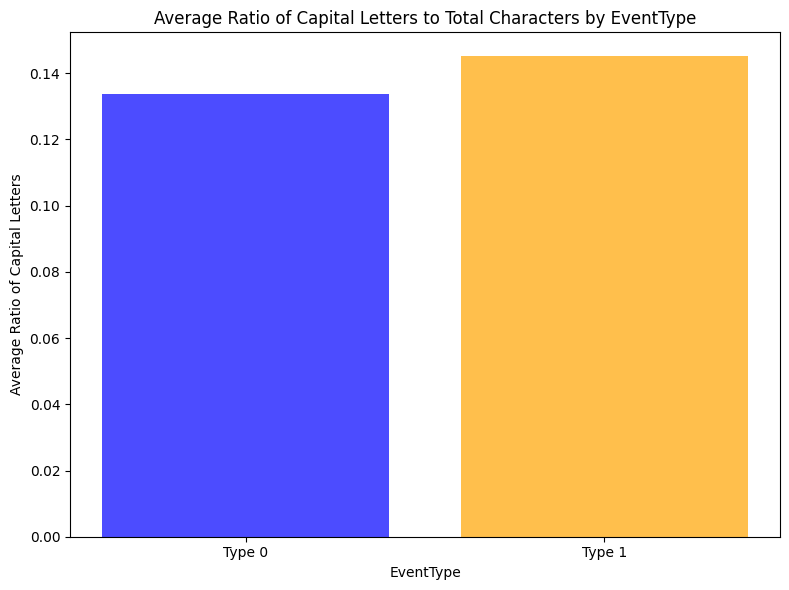

100%|██████████| 5056050/5056050 [00:08<00:00, 607190.79it/s]


   EventType  Total_Count
0          0         6434
1          1        11174
Average Ratio of Football Terms to Total Words by EventType:
   EventType  FootballWordRatio
0          0           0.000204
1          1           0.000288
Total Count of Football Terms by EventType:
   EventType  Total_Count
0          0         6434
1          1        11174


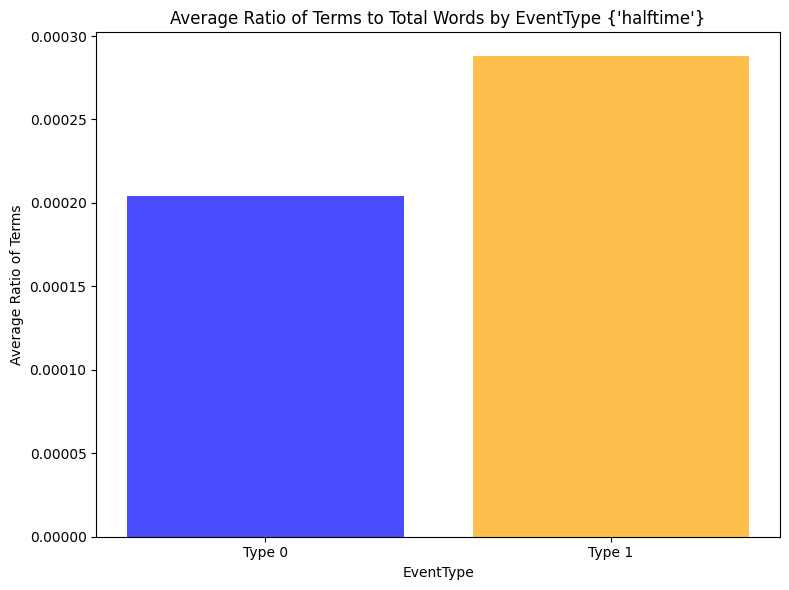

100%|██████████| 5056050/5056050 [00:08<00:00, 568359.19it/s]


   EventType  Total_Count
0          0        27043
1          1        37318
Average Ratio of Football Terms to Total Words by EventType:
   EventType  FootballWordRatio
0          0           0.000944
1          1           0.001052
Total Count of Football Terms by EventType:
   EventType  Total_Count
0          0        27043
1          1        37318


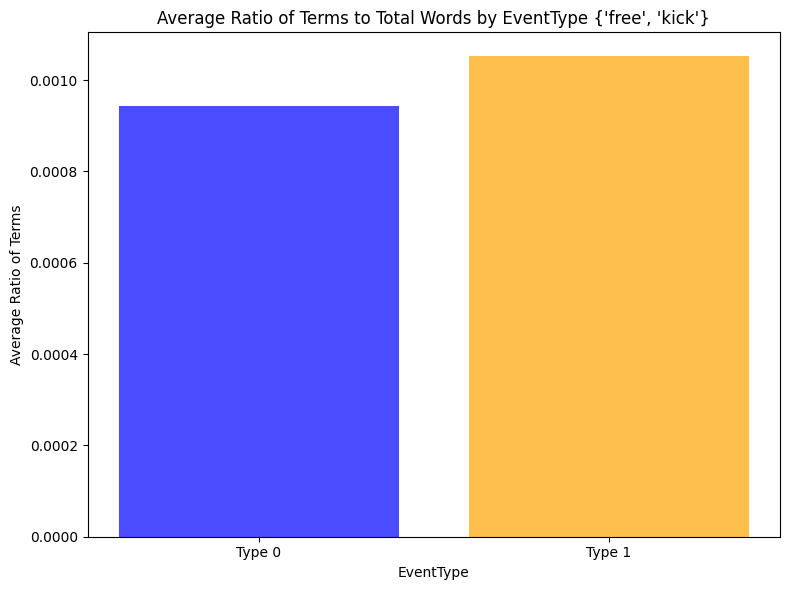

In [41]:
def analyze_symbol_ratio(df, char, event_column='EventType', text_column='Tweet'):
    """
    Analyse le ratio moyen d'un caractère donné dans un DataFrame, par catégorie d'EventType.
    
    :param df: DataFrame contenant les données
    :param char: Caractère ou symbole à analyser (par exemple, "?", "!", ".")
    :param event_column: Colonne représentant les catégories d'événements
    :param text_column: Colonne contenant le texte à analyser
    """
    # Fonction pour compter le caractère dans chaque texte
    def count_character(text):
        return text.count(char)
    
    # Calculer le nombre total de caractères par tweet
    df['TotalChars'] = df[text_column].apply(len)
    
    # Calculer le nombre d'occurrences du caractère spécifié
    df[f'{char}Count'] = df[text_column].apply(count_character)
    
    # Calculer le ratio du caractère par rapport au nombre total de caractères
    df[f'{char}Ratio'] = df[f'{char}Count'] / df['TotalChars']
    
    # Calculer la moyenne des ratios par EventType
    average_ratios = df.groupby(event_column)[f'{char}Ratio'].mean().reset_index()
    
    # Afficher les résultats
    print(f"Moyenne du ratio de '{char}' par {event_column} :")
    print(average_ratios)
    
    # Tracer un graphique pour comparer les ratios moyens
    plt.figure(figsize=(8, 6))
    plt.bar(
        average_ratios[event_column], 
        average_ratios[f'{char}Ratio'], 
        alpha=0.7, 
        color=['blue', 'orange']
    )
    plt.title(f"Moyenne du Ratio de '{char}' par {event_column}")
    plt.xlabel(event_column)
    plt.ylabel(f"Moyenne du Ratio de '{char}'")
    plt.xticks(average_ratios[event_column])
    plt.tight_layout()
    plt.show()


# analyze_symbol_ratio(df, '?')
# analyze_symbol_ratio(df, '!')
# analyze_symbol_ratio(df, '.')
# analyze_symbol_ratio(df, '#')
# analyze_symbol_ratio(df, '@')
# analyze_symbol_ratio(df, 'https://')
# analyze_symbol_ratio(df, 'www.')
# analyze_symbol_ratio(df, 'http://')
analyse_terms({"halftime"}, df)
analyse_terms({"free", "kick"}, df)

Average Length of Tweets by EventType:
   EventType  AvgCharLength  AvgWordLength
0          0      87.964981      13.829524
1          1      86.731132      13.813918


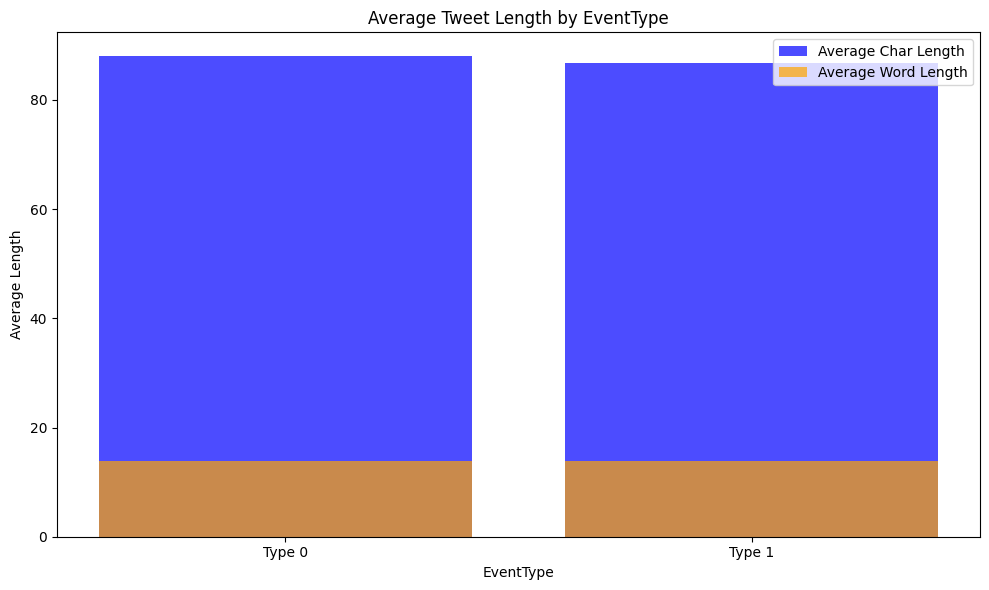

In [36]:
df['CharLength'] = df['Tweet'].apply(len)  # Length in characters
df['WordLength'] = df['Tweet'].apply(lambda x: len(x.split()))  # Length in words

# Group by EventType and calculate the average length
average_lengths = df.groupby('EventType').agg(
    AvgCharLength=('CharLength', 'mean'),
    AvgWordLength=('WordLength', 'mean')
).reset_index()

# Display the results
print("Average Length of Tweets by EventType:")
print(average_lengths)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot average character length
plt.bar(average_lengths['EventType'], average_lengths['AvgCharLength'], alpha=0.7, color='blue', label='Average Char Length')

# Plot average word length
plt.bar(average_lengths['EventType'], average_lengths['AvgWordLength'], alpha=0.7, color='orange', label='Average Word Length')

plt.title("Average Tweet Length by EventType")
plt.xlabel("EventType")
plt.ylabel("Average Length")
plt.xticks(average_lengths['EventType'], labels=["Type 0", "Type 1"])
plt.legend()
plt.tight_layout()
plt.show()

Average Number of Words with Repeated Letters by EventType:
   EventType  RepeatedLetters
0          0         0.054193
1          1         0.069891


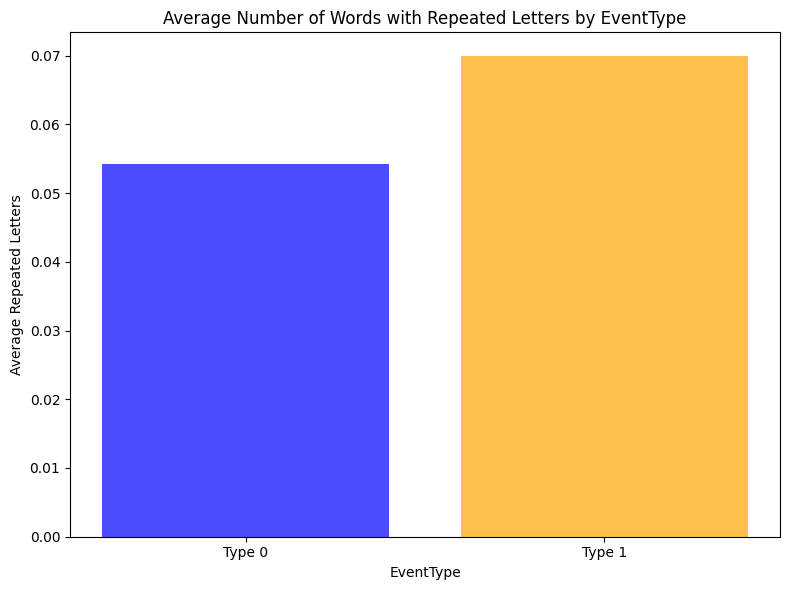


Tweets with Repeated Letters:
                                                     Tweet  RepeatedLetters
132      australia 0 - 3 Netherlands RT"@THEBEAT999FM: ...                1
142      RT @brazil_agent: Why you should take a break ...                1
156      I’m gearing up for the #WorldCup. Who are you ...                1
189      Esok kelas start at 12pm yeahhh worldcup all n...                1
240      #realmadrid #halamadrid #worldcup #fifa #footb...                1
...                                                    ...              ...
5055965  Woooww Ghana naa u did well tho, should've won...                4
5055983  “@Dookey_Da_Shyt: Ghana, Ivory Coast and Niger...                2
5055989  I guess you guys can celebrate ... Because Gha...                1
5055998  RT @letshugbro: NOT ONLY IS THERE A PLAYER CAL...                1
5056043  @ItsToluNotTulu it's called Ghana but you ain'...                1

[243811 rows x 2 columns]


In [37]:
# Function to count repeated letters in a word
def count_repeated_letters(text):
    repeated_count = 0
    words = text.split()
    for word in words:
        # Find letter repetitions using regex (e.g., "goooal", "yeeees")
        matches = re.findall(r'(\w)\1{2,}', word.lower())  # Match any letter repeated 3+ times
        repeated_count += len(matches)  # Count the number of words with repetitions
    return repeated_count

# Apply the function to count repeated letters in each tweet
df['RepeatedLetters'] = df['Tweet'].apply(count_repeated_letters)

# Calculate the average number of repeated letters by EventType
average_repeated_letters = df.groupby('EventType')['RepeatedLetters'].mean().reset_index()

# Display the results
print("Average Number of Words with Repeated Letters by EventType:")
print(average_repeated_letters)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.bar(
    average_repeated_letters['EventType'],
    average_repeated_letters['RepeatedLetters'],
    alpha=0.7,
    color=['blue', 'orange']
)
plt.title("Average Number of Words with Repeated Letters by EventType")
plt.xlabel("EventType")
plt.ylabel("Average Repeated Letters")
plt.xticks(average_repeated_letters['EventType'], labels=["Type 0", "Type 1"])
plt.tight_layout()
plt.show()

# Show examples of tweets with repeated letters
print("\nTweets with Repeated Letters:")
print(df[df['RepeatedLetters'] > 0][['Tweet', 'RepeatedLetters']])

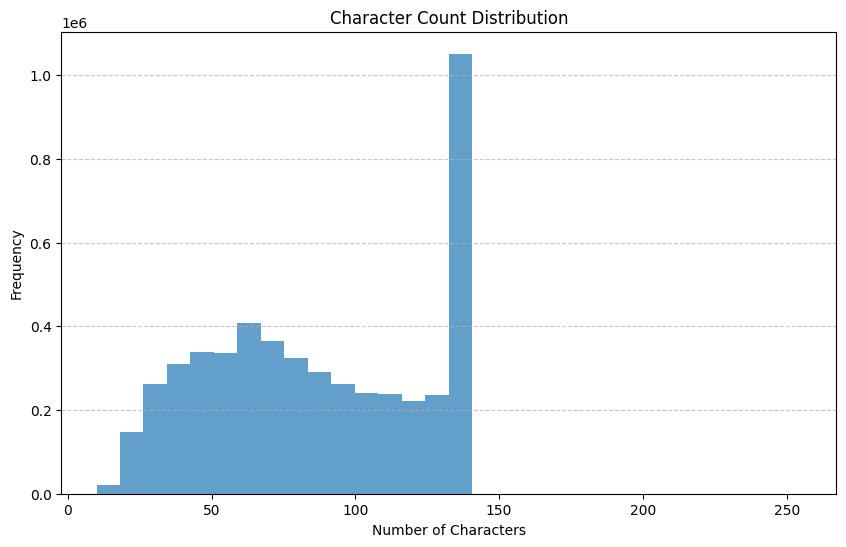

In [28]:
# Analyze tweets: number of characters, language, and hashtags
df['Character_Count'] = df['Tweet'].apply(len)
# Plot histogram of character counts
plt.figure(figsize=(10, 6))
df['Character_Count'].plot(kind='hist', bins=30, alpha=0.7)
plt.title("Character Count Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


begin of select
end of select
begin of count words 0
end of count words 0
begin of count words 1
end of count words 1


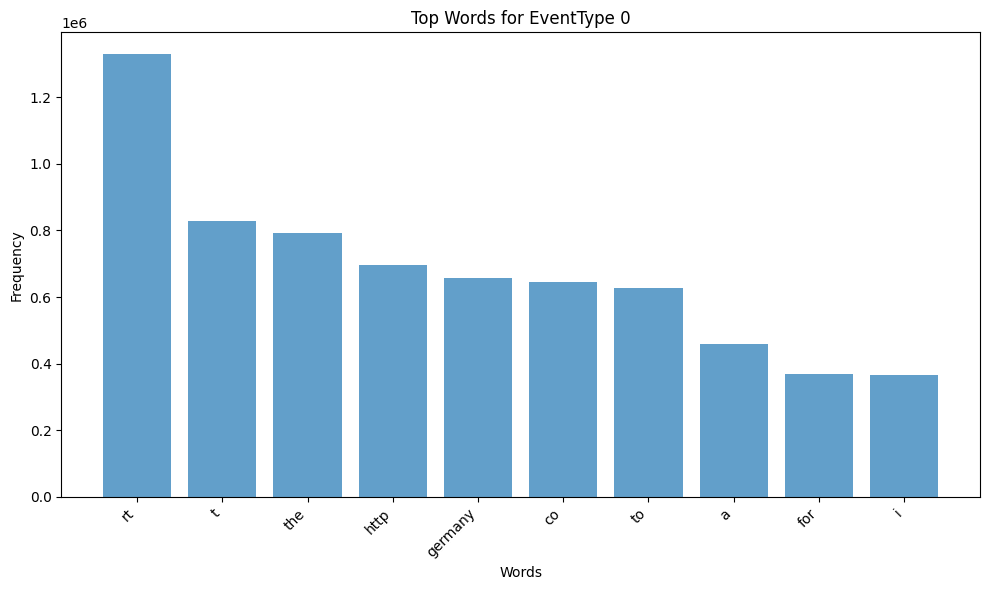

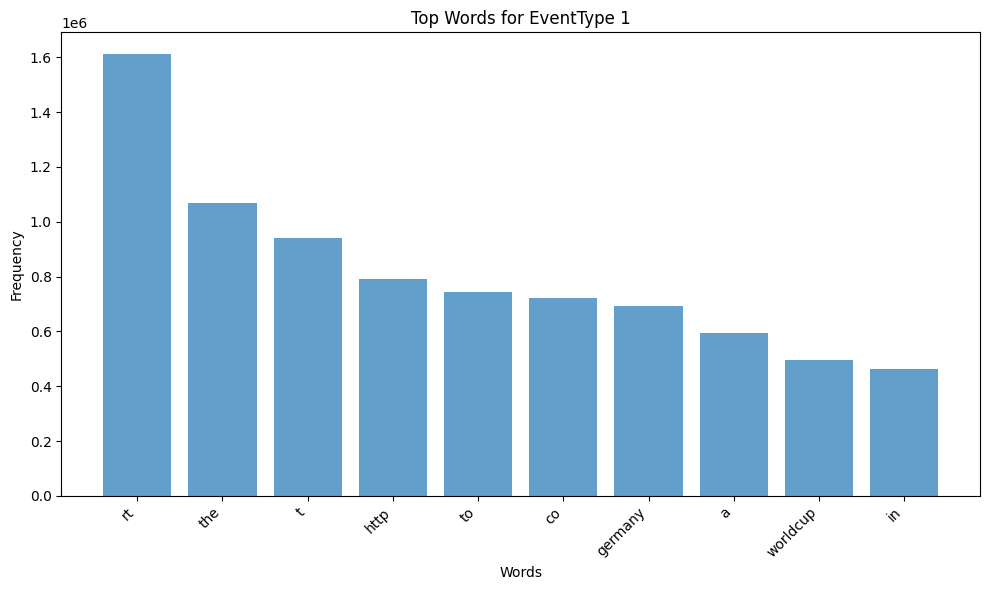

In [50]:
from collections import Counter
import re

# Function to extract words from tweets
def extract_words(text):
    # Remove hashtags, mentions, and non-alphanumeric characters, and split into words
    return re.findall(r'\b\w+\b', text.lower())

# Filter tweets by EventType
print('begin of select')
event_type_0 = df[df['EventType'] == 0]['Tweet']
event_type_1 = df[df['EventType'] == 1]['Tweet']
print('end of select')

# Count word frequencies for each EventType
print('begin of count words 0')
words_0 = Counter(word for tweet in event_type_0 for word in extract_words(tweet))
print('end of count words 0')
print('begin of count words 1')
words_1 = Counter(word for tweet in event_type_1 for word in extract_words(tweet))
print('end of count words 1')

# Convert to DataFrames for easier analysis
words_0_df = pd.DataFrame(words_0.most_common(10), columns=['Word', 'Count'])
words_1_df = pd.DataFrame(words_1.most_common(10), columns=['Word', 'Count'])

# Plot top words for EventType 0
plt.figure(figsize=(10, 6))
plt.bar(words_0_df['Word'], words_0_df['Count'], alpha=0.7)
plt.title("Top Words for EventType 0")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top words for EventType 1
plt.figure(figsize=(10, 6))
plt.bar(words_1_df['Word'], words_1_df['Count'], alpha=0.7)
plt.title("Top Words for EventType 1")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top Words Favoring EventType 1 to 0:
                Word  Count_0  Count_1  Ratio_1_to_0  Ratio_0_to_1
502           cmrbra      763    13289     17.416776      0.057416
630        qualified     2405    18926      7.869439      0.127074
597           cromex     1356    10330      7.617994      0.131268
130              cmr    14595    83890      5.747859      0.173978
655               ft     4554    26156      5.743522      0.174109
159            villa     4135    23212      5.613543      0.178141
258  congratulations     3278    17036      5.197071      0.192416
594         deserved     1700     8634      5.078824      0.196896
9             torres     1716     8702      5.071096      0.197196
324       eliminated     4639    23181      4.996982      0.200121
323            tears     2544    12280      4.827044      0.207166
712         congrats     2519    11953      4.745137      0.210742
634     easportsfifa     2345    10888      4.643070      0.215375
164           cahill     

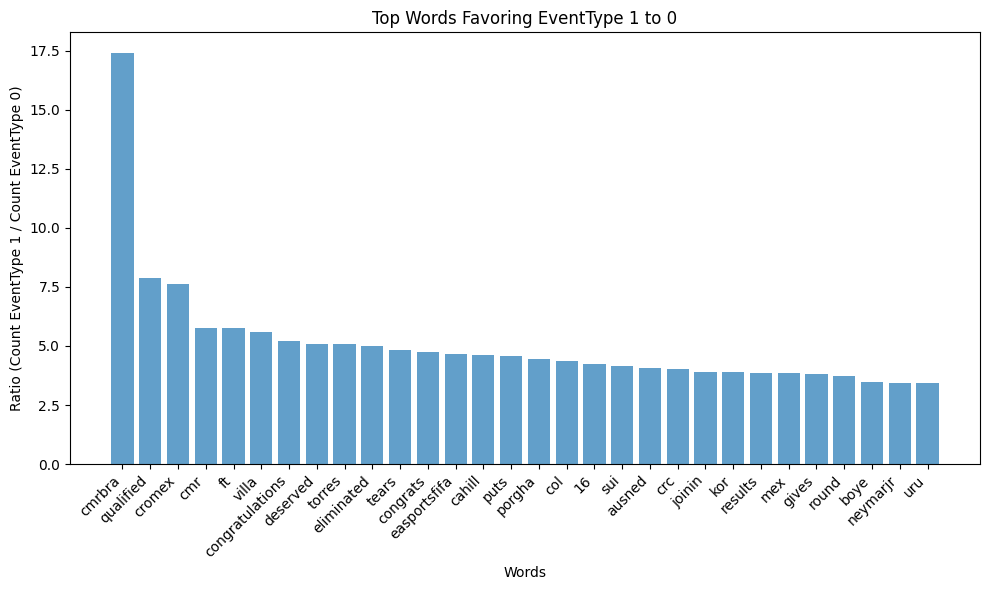

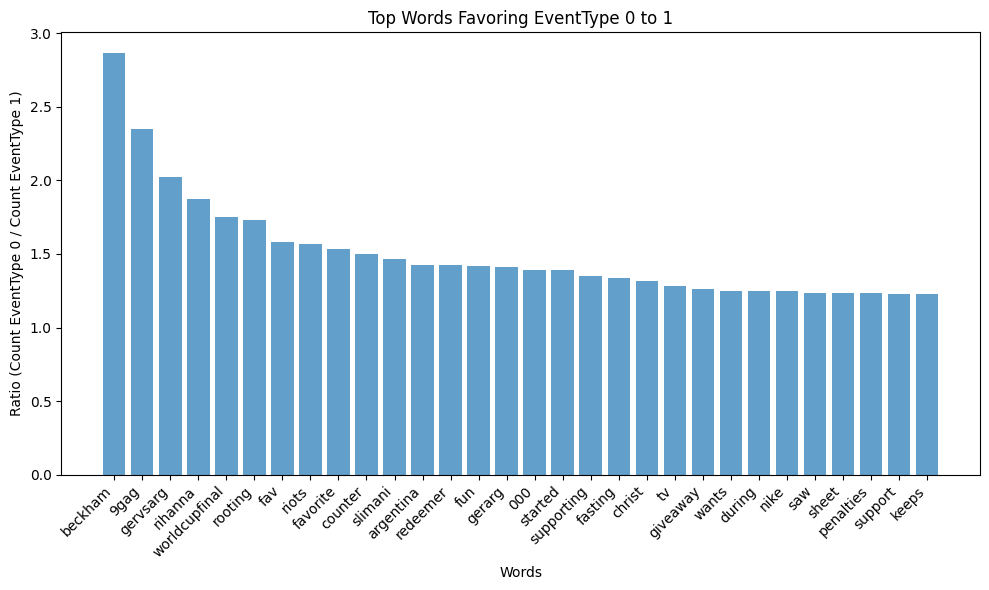

In [53]:
# Set a minimum threshold for word appearances
min_appearance = 1e4
# Combine the counts into a DataFrame for analysis
all_words = set(words_0.keys()).union(set(words_1.keys()))
word_ratios = []

for word in all_words:
    count_0 = words_0.get(word, 0)
    count_1 = words_1.get(word, 0)
    if count_0 + count_1 >= min_appearance:  # Ensure minimum appearances
        ratio_1_to_0 = count_1 / count_0 if count_0 > 0 else float('inf')
        ratio_0_to_1 = count_0 / count_1 if count_1 > 0 else float('inf')
        word_ratios.append({'Word': word, 'Count_0': count_0, 'Count_1': count_1, 
                            'Ratio_1_to_0': ratio_1_to_0, 'Ratio_0_to_1': ratio_0_to_1})

# Convert to a DataFrame for easier analysis
word_ratios_df = pd.DataFrame(word_ratios)

# Find top 10 words with highest EventType 1 to 0 ratios
top_words_1_to_0 = word_ratios_df.sort_values(by='Ratio_1_to_0', ascending=False).head(30)

# Find top 10 words with highest EventType 0 to 1 ratios
top_words_0_to_1 = word_ratios_df.sort_values(by='Ratio_0_to_1', ascending=False).head(30)

# Display the results
print("Top Words Favoring EventType 1 to 0:")
print(top_words_1_to_0)

print("\nTop Words Favoring EventType 0 to 1:")
print(top_words_0_to_1)

# Plot the results for EventType 1 to 0
plt.figure(figsize=(10, 6))
plt.bar(top_words_1_to_0['Word'], top_words_1_to_0['Ratio_1_to_0'], alpha=0.7)
plt.title("Top Words Favoring EventType 1 to 0")
plt.xlabel("Words")
plt.ylabel("Ratio (Count EventType 1 / Count EventType 0)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the results for EventType 0 to 1
plt.figure(figsize=(10, 6))
plt.bar(top_words_0_to_1['Word'], top_words_0_to_1['Ratio_0_to_1'], alpha=0.7)
plt.title("Top Words Favoring EventType 0 to 1")
plt.xlabel("Words")
plt.ylabel("Ratio (Count EventType 0 / Count EventType 1)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

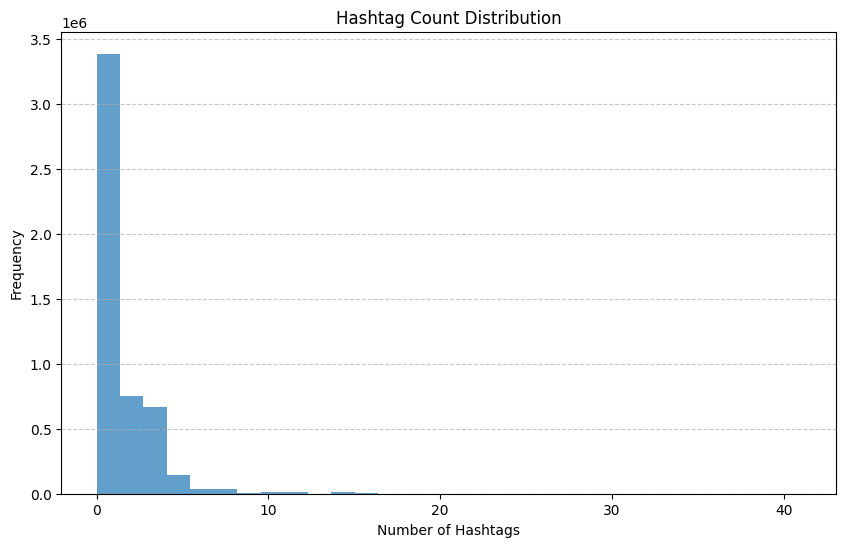

In [29]:
df['Hashtag_Count'] = df['Tweet'].apply(lambda x: x.count('#'))
# Plot histogram of hashtag counts
plt.figure(figsize=(10, 6))
df['Hashtag_Count'].plot(kind='hist', bins=30, alpha=0.7)
plt.title("Hashtag Count Distribution")
plt.xlabel("Number of Hashtags")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

         Hashtag   Count
33           GER  626177
9       WorldCup  566067
21           BRA  279361
75           ARG  265443
5            FRA  216471
25      worldcup  202013
16           MEX  185310
11           NED  174656
17  WorldCup2014  172499
37           POR  150412


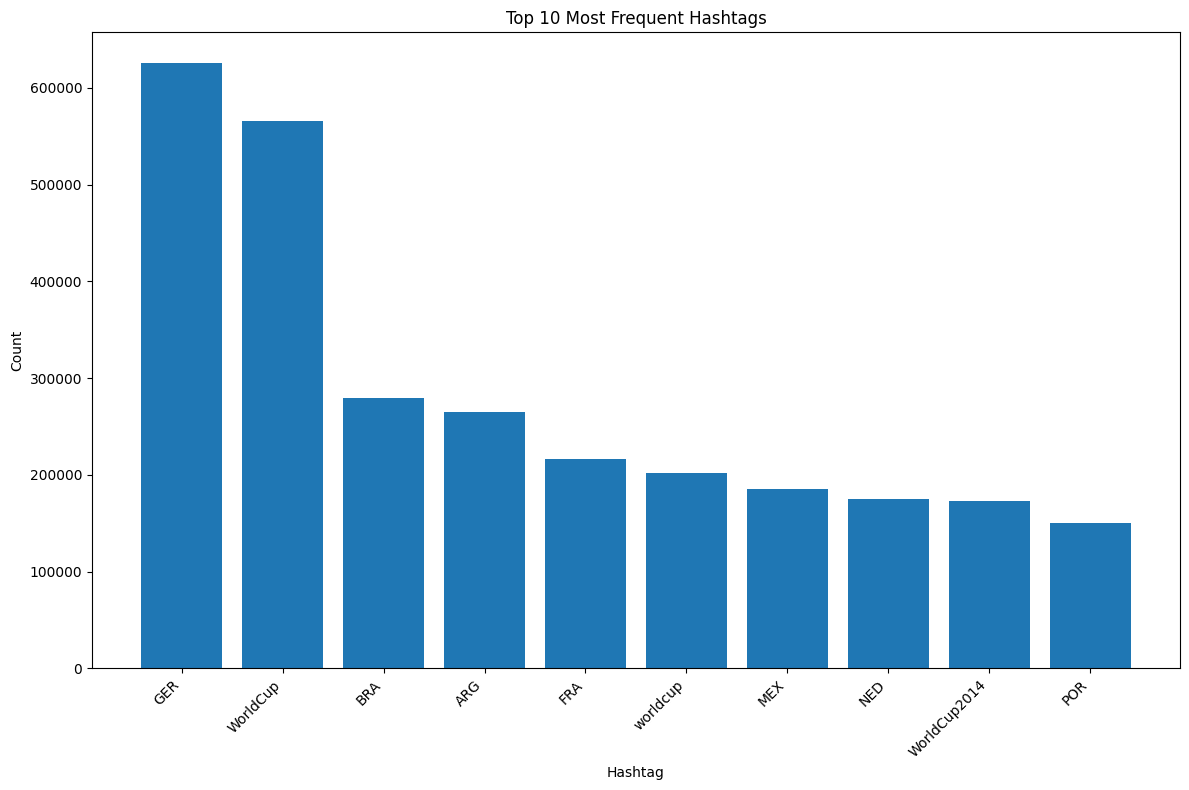

In [46]:

# Function to extract hashtags from a tweet
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

# Apply the function to extract hashtags from all tweets
df['Hashtags'] = df['Tweet'].apply(extract_hashtags)

# Flatten the list of lists of hashtags and count occurrences
all_hashtags = [hashtag for hashtags in df['Hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)

# Convert to a DataFrame for easy analysis
hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Count']).sort_values(by='Count', ascending=False)

# Display the top 10 most frequent hashtags
top_hashtags = hashtag_df.head(10)
print(top_hashtags)


plt.figure(figsize=(12, 8))
plt.bar(top_hashtags['Hashtag'], top_hashtags['Count'])
plt.title("Top 10 Most Frequent Hashtags")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [3]:

# Function to safely classify a single tweet
def safe_classify(text):
    if text.strip():
        try:
            if classify(text)[0]=='en':
                return 'en'
            else:
                return 'non-en'
        except Exception as e:
            return 'error'  # Return 'error' if classification fails
    else:
        return 'non-en'

tqdm.pandas()

# Apply langid to the sampled data
arranged_tweet = df['Tweet'].fillna('').astype(str)
df['Language'] = arranged_tweet.progress_apply(safe_classify)

# Plot histogram of language distribution
plt.figure(figsize=(10, 6))
df['Language'].value_counts().plot(kind='bar', alpha=0.7)
plt.title("Language Distribution")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

  1%|▏         | 66858/5056050 [00:22<28:05, 2959.40it/s]


KeyboardInterrupt: 

In [ ]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

print("Downloading NLP models...")
nltk.download('stopwords')
print("Stopwords downloaded.")
nltk.download('wordnet')
print("Wordnet downloaded.")
# Load GloVe model with Gensim's AP
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)
print("Preprocessing tweets...")
tqdm.pandas()
df['Tweet'] = df['Tweet'].progress_apply(preprocess_text)
print("Tweets preprocessed.")

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-b/2022/mohamed.aloulou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-b/2022/mohamed.aloulou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Stopwords downloaded.
Wordnet downloaded.
Preprocessing tweets...


 93%|█████████▎| 4715722/5056050 [37:12<02:26, 2330.70it/s]

In [ ]:
# Save the DataFrame to a text file in the "data" directory
file_path = "../data/tweets.txt"

# Save the DataFrame as a tab-separated file (or modify the separator if needed)
df.to_csv(file_path, sep='\t', index=False, header=True)

print(f"DataFrame has been saved to {file_path}")